In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics.cluster import contingency_matrix



#constants
random_state = 42
plotColor = ['b','g','r','m','c', 'y']
markers = ['+','o','*','^','v','>','<']

#set up
sns.set(style='white')
%matplotlib inline

In [2]:
data = pd.read_csv('ClassifyRisk.txt', sep=',')
data.head()

,mortgage,loans,age,marital_status,income,risk
0,y,3,34,other,28060.70,bad loss
1,n,2,37,other,28009.34,bad loss
2,n,2,29,other,27614.60,bad loss
3,y,2,33,other,27287.18,bad loss
4,y,2,39,other,26954.06,bad loss


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   mortgage        246 non-null    object 
 1   loans           246 non-null    int64  
 2   age             246 non-null    int64  
 3   marital_status  246 non-null    object 
 4   income          246 non-null    float64
 5   risk            246 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 11.7+ KB


In [4]:
data.describe()

,loans,age,income
count,246.000000,246.000000,246.000000
mean,1.308943,40.642276,38789.516748
std,0.843995,10.897017,13882.704336
min,0.000000,17.000000,15301.250000
25%,1.000000,32.000000,26881.520000
50%,1.000000,41.000000,37662.000000
75%,2.000000,50.000000,49398.227500
max,3.000000,66.000000,78398.620000


In [5]:
data.isna().any()

mortgage          False
loans             False
age               False
marital_status    False
income            False
risk              False
dtype: bool

In [6]:
data['marital_status'].value_counts()

single     111
married     78
other       57
Name: marital_status, dtype: int64

In [7]:
data['risk'].value_counts()

bad loss     123
good risk    123
Name: risk, dtype: int64

## Encode the categorical values

In [8]:
data_encoded = pd.get_dummies(data, columns=['mortgage','marital_status'], drop_first=True)
data_encoded.head()

,loans,age,income,risk,mortgage_y,marital_status_other,marital_status_single
0,3,34,28060.70,bad loss,1,1,0
1,2,37,28009.34,bad loss,0,1,0
2,2,29,27614.60,bad loss,0,1,0
3,2,33,27287.18,bad loss,1,1,0
4,2,39,26954.06,bad loss,1,1,0


In [9]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   loans                  246 non-null    int64  
 1   age                    246 non-null    int64  
 2   income                 246 non-null    float64
 3   risk                   246 non-null    object 
 4   mortgage_y             246 non-null    uint8  
 5   marital_status_other   246 non-null    uint8  
 6   marital_status_single  246 non-null    uint8  
dtypes: float64(1), int64(2), object(1), uint8(3)
memory usage: 8.5+ KB


## Formating Dataset

In [10]:
x = data_encoded.iloc[:,[0,1,2,4,5,6]]
y = data_encoded.iloc[:,3]
x.head()

,loans,age,income,mortgage_y,marital_status_other,marital_status_single
0,3,34,28060.70,1,1,0
1,2,37,28009.34,0,1,0
2,2,29,27614.60,0,1,0
3,2,33,27287.18,1,1,0
4,2,39,26954.06,1,1,0


In [11]:
y = pd.get_dummies(y, columns=['risk'], drop_first=True)

## Normalization

In [12]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x[['loans','age','income']] = sc.fit_transform(x[['loans','age','income']])

<ipython-input-12-90e6181a79a7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[['loans','age','income']] = sc.fit_transform(x[['loans','age','income']])
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [13]:
x.head()

,loans,age,income,mortgage_y,marital_status_other,marital_status_single
0,2.007718,-0.610793,-0.774395,1,1,0
1,0.820462,-0.334927,-0.778102,0,1,0
2,0.820462,-1.070569,-0.806594,0,1,0
3,0.820462,-0.702748,-0.830226,1,1,0
4,0.820462,-0.151016,-0.854271,1,1,0


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.6, random_state = 22,shuffle = True)

# Decision Tree classifier

In [15]:
clf_dt = DecisionTreeClassifier(random_state=0)
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [16]:
y_pred=clf_dt.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9256756756756757

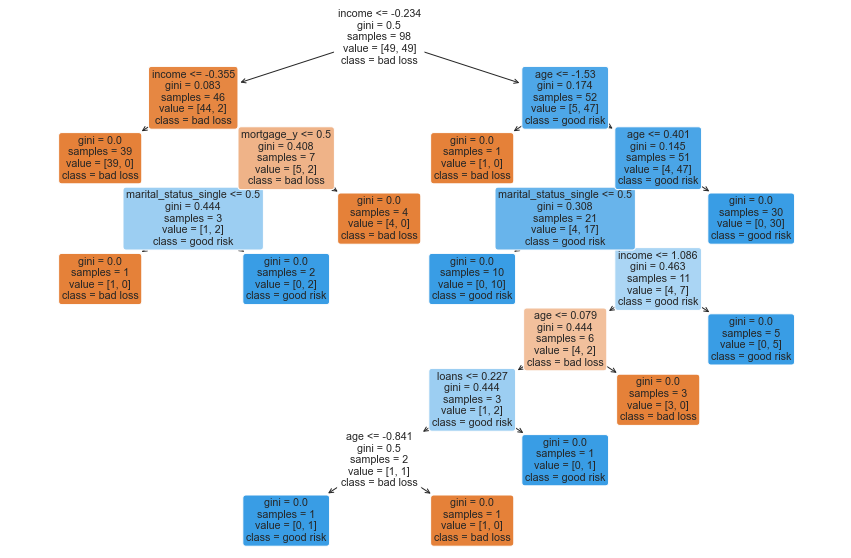

In [17]:
from sklearn import tree
plt.figure(figsize=(15, 10))
tree.plot_tree(clf_dt, filled=True, rounded=True, 
          class_names=["bad loss", "good risk"], feature_names=x.columns);

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        74
           1       0.92      0.92      0.92        74

    accuracy                           0.92       148
   macro avg       0.92      0.92      0.92       148
weighted avg       0.92      0.92      0.92       148



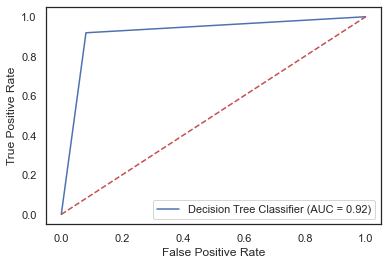

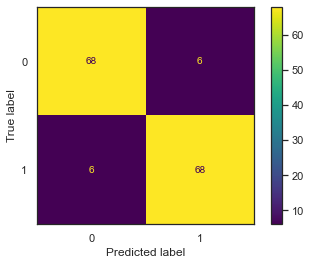

In [18]:
dtclf = DecisionTreeClassifier(random_state = 12)
dtclf = dtclf.fit(X_train,y_train)
y_pred = dtclf.predict(X_test)
print(classification_report(y_test, y_pred))
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred,drop_intermediate=False)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Decision Tree Classifier')
display.plot()  # doctest: +SKIP
plt.plot([0, 1], [0, 1],'r--')
plt.show() 
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm,display_labels=[0,1]).plot()

## Post Pruning with cost complexity pruning

In [19]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [20]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=12, ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clfs.append(clf_dt)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.3687290969899666


## Accuracy vs alpha for training and testing sets

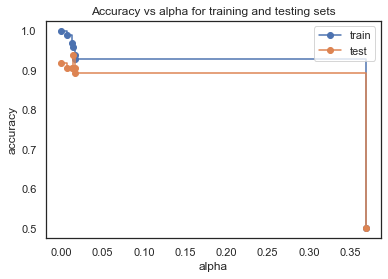

In [21]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clfs]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [22]:
clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=0.016)
clf_dt.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.016, random_state=0)

In [23]:
y_pred=clf_dt.predict(X_test)
accuracy_score(y_test, y_pred)


0.9391891891891891

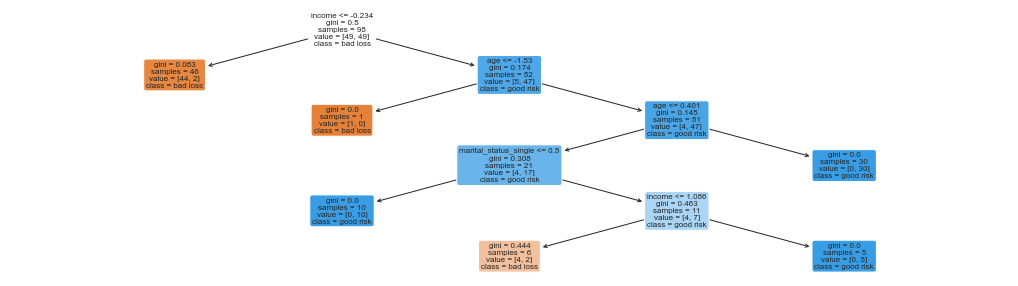

In [24]:
plt.figure(figsize=(18, 5))
tree.plot_tree(clf_dt, filled=True, rounded=True, 
          class_names=["bad loss", "good risk"], feature_names=x.columns);

              precision    recall  f1-score   support

           0       0.92      0.96      0.94        74
           1       0.96      0.92      0.94        74

    accuracy                           0.94       148
   macro avg       0.94      0.94      0.94       148
weighted avg       0.94      0.94      0.94       148



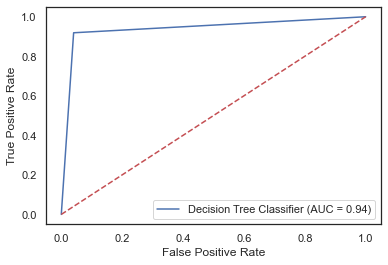

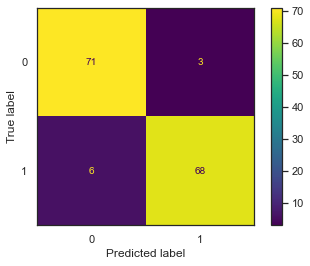

In [25]:
print(classification_report(y_test, y_pred))
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred,drop_intermediate=False)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Decision Tree Classifier')
display.plot()  
plt.plot([0, 1], [0, 1],'r--')
plt.show() 
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm,display_labels=[0,1]).plot()

In [26]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


XG BOOST

In [27]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold

xgbc = XGBClassifier()
print(xgbc)


XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)


In [28]:
xgbc.fit(X_train,y_train)


[09:57:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [29]:
scores = cross_val_score(xgbc, X_train, y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassif

[09:57:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:57:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:57:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:57:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [30]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbc, X_train, y_train, cv=kfold )

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassif

[09:57:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:57:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:57:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:57:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\lib

In [31]:
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: 0.91


In [32]:
ypred = xgbc.predict(X_test)
cm = confusion_matrix(y_test,ypred)
print(cm)

[[65  9]
 [ 2 72]]


              precision    recall  f1-score   support

           0       0.97      0.88      0.92        74
           1       0.89      0.97      0.93        74

    accuracy                           0.93       148
   macro avg       0.93      0.93      0.93       148
weighted avg       0.93      0.93      0.93       148



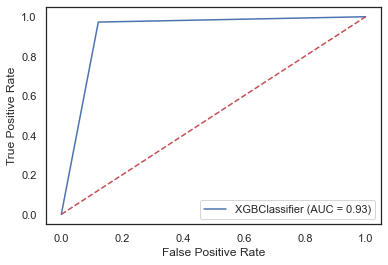

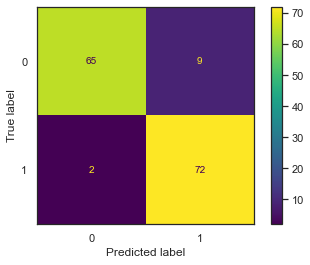

In [33]:
print(classification_report(y_test, ypred))
fpr, tpr, thresholds = metrics.roc_curve(y_test,ypred,drop_intermediate=False)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='XGBClassifier')
display.plot()  
plt.plot([0, 1], [0, 1],'r--')
plt.show() 
cm = confusion_matrix(y_test, ypred)
cm_display = ConfusionMatrixDisplay(cm,display_labels=[0,1]).plot()

In [34]:
from sklearn.ensemble import BaggingClassifier
bag_model=BaggingClassifier(base_estimator=clf_dt, n_estimators=100, bootstrap=True)
bag_model=bag_model.fit(X_train,y_train)
ytest_pred=bag_model.predict(X_test)
print(bag_model.score(X_test, y_test))
print(confusion_matrix(y_test, ytest_pred)) 


0.9121621621621622
[[64 10]
 [ 3 71]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.96      0.86      0.91        74
           1       0.88      0.96      0.92        74

    accuracy                           0.91       148
   macro avg       0.92      0.91      0.91       148
weighted avg       0.92      0.91      0.91       148



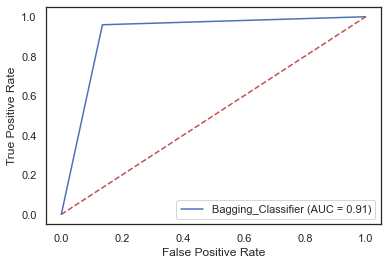

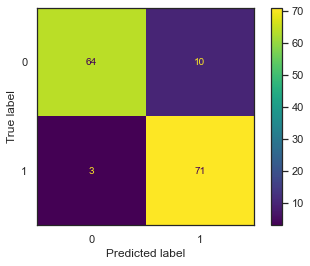

In [35]:
print(classification_report(y_test, ytest_pred))
fpr, tpr, thresholds = metrics.roc_curve(y_test,ytest_pred,drop_intermediate=False)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Bagging_Classifier')
display.plot()  
plt.plot([0, 1], [0, 1],'r--')
plt.show() 
cm = confusion_matrix(y_test, ytest_pred)
cm_display = ConfusionMatrixDisplay(cm,display_labels=[0,1]).plot()

In [36]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred_randomforest=clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_randomforest))

Accuracy: 0.9527027027027027


<ipython-input-36-6c7d10eb2b3c>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train,y_train)


              precision    recall  f1-score   support

           0       0.99      0.92      0.95        74
           1       0.92      0.99      0.95        74

    accuracy                           0.95       148
   macro avg       0.95      0.95      0.95       148
weighted avg       0.95      0.95      0.95       148



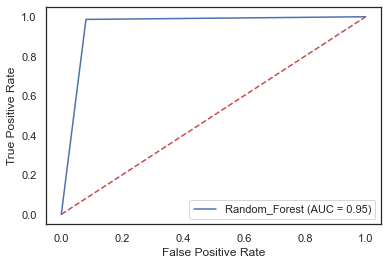

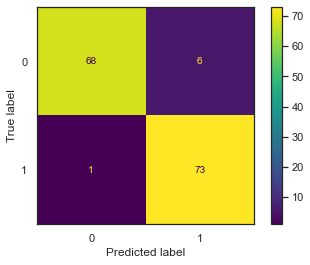

In [37]:
print(classification_report(y_test, y_pred_randomforest))
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred_randomforest,drop_intermediate=False)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Random_Forest')
display.plot()  
plt.plot([0, 1], [0, 1],'r--')
plt.show() 
cm = confusion_matrix(y_test, y_pred_randomforest)
cm_display = ConfusionMatrixDisplay(cm,display_labels=[0,1]).plot()

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
model.fit(X_train,y_train)
y_pred_grad_boost=model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_grad_boost))

Accuracy: 0.9121621621621622


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.94      0.88      0.91        74
           1       0.89      0.95      0.92        74

    accuracy                           0.91       148
   macro avg       0.91      0.91      0.91       148
weighted avg       0.91      0.91      0.91       148



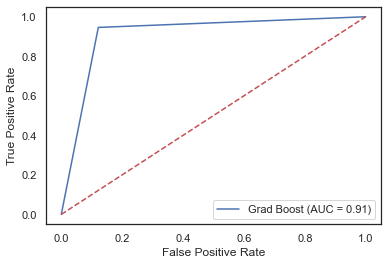

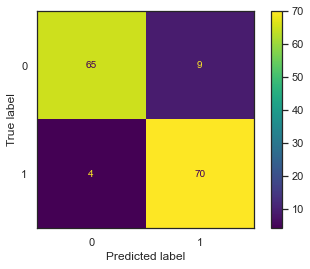

In [39]:
print(classification_report(y_test, y_pred_grad_boost))
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred_grad_boost,drop_intermediate=False)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Grad Boost')
display.plot()  
plt.plot([0, 1], [0, 1],'r--')
plt.show() 
cm = confusion_matrix(y_test, y_pred_grad_boost)
cm_display = ConfusionMatrixDisplay(cm,display_labels=[0,1]).plot()